In [1]:
from scipy.special import logsumexp

In [2]:
!pip install hmmlearn

In [3]:
import scipy.io.wavfile as wavfile
import os
import numpy as np
from glob import glob
from hmmlearn import hmm
import MFCC
import numpy as np
import re
import random
import matplotlib
matplotlib.use('nbAgg')
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

## Problem 1

Write a function which accepts a GMMHMM as well as
an integer n_sim, and which simulates the GMMHMM process, generating n_sim different
observations. Use the example GMMHMM to sample 900 times. Use PCA from SkLearn to plot your generated observations in 2D space. Color observations by state.

In [4]:
def sample_gmmhmm(gmmhmm, n_sim):
    """
    Simulate from a GMMHMM.
    
    Returns
    -------
    states : ndarray of shape (n_sim,)
        The sequence of states
    obs : ndarray of shape (n_sim, M)
        The generated observations (vectors of length M)
        
    """
    A, weights, means, covars, pi = gmmhmm
    state = np.argmax(np.random.multinomial(1, pi))
    sample_component = np.argmax(np.random.multinomial(1, weights[state,:]))
    sample = np.random.multivariate_normal(means[state, sample_component, :], covars[state, sample_component, :, :])
    states = [state]
    obs = [sample]
    #simulate and sample
    for i in range(n_sim):
        state = np.argmax(np.random.multinomial(1, A[:, state]))
        sample_component = np.argmax(np.random.multinomial(1, weights[state,:]))
        sample = np.random.multivariate_normal(means[state, sample_component, :], covars[state, sample_component, :, :])
        states.append(state)
        obs.append(sample)
        
    states = np.array(states)
    obs = np.array(obs)
    
    return states,obs

In [5]:
T = 900
A = np.array([[.3, .3, .4], [.2, .3, .5], [.3, .2, .5]])
weights = np.array([[.3, .2, .1, .2, .2], [.1, .3, .3, .2, .1],[.1, .3, .2, .1, .3]])
means = np.array([np.floor(np.random.uniform(-100, 100, size = (5, 4))) for i in range(3)])
covars = np.array([[np.floor(np.random.uniform(1, 20))*np.eye(4) for i in range(5)] for j in range(3)])
pi = np.array([.15, .15, .7])
gmmhmm = [A, weights, means, covars, pi]
states,obs = sample_gmmhmm(gmmhmm,T)   

<IPython.core.display.Javascript object>


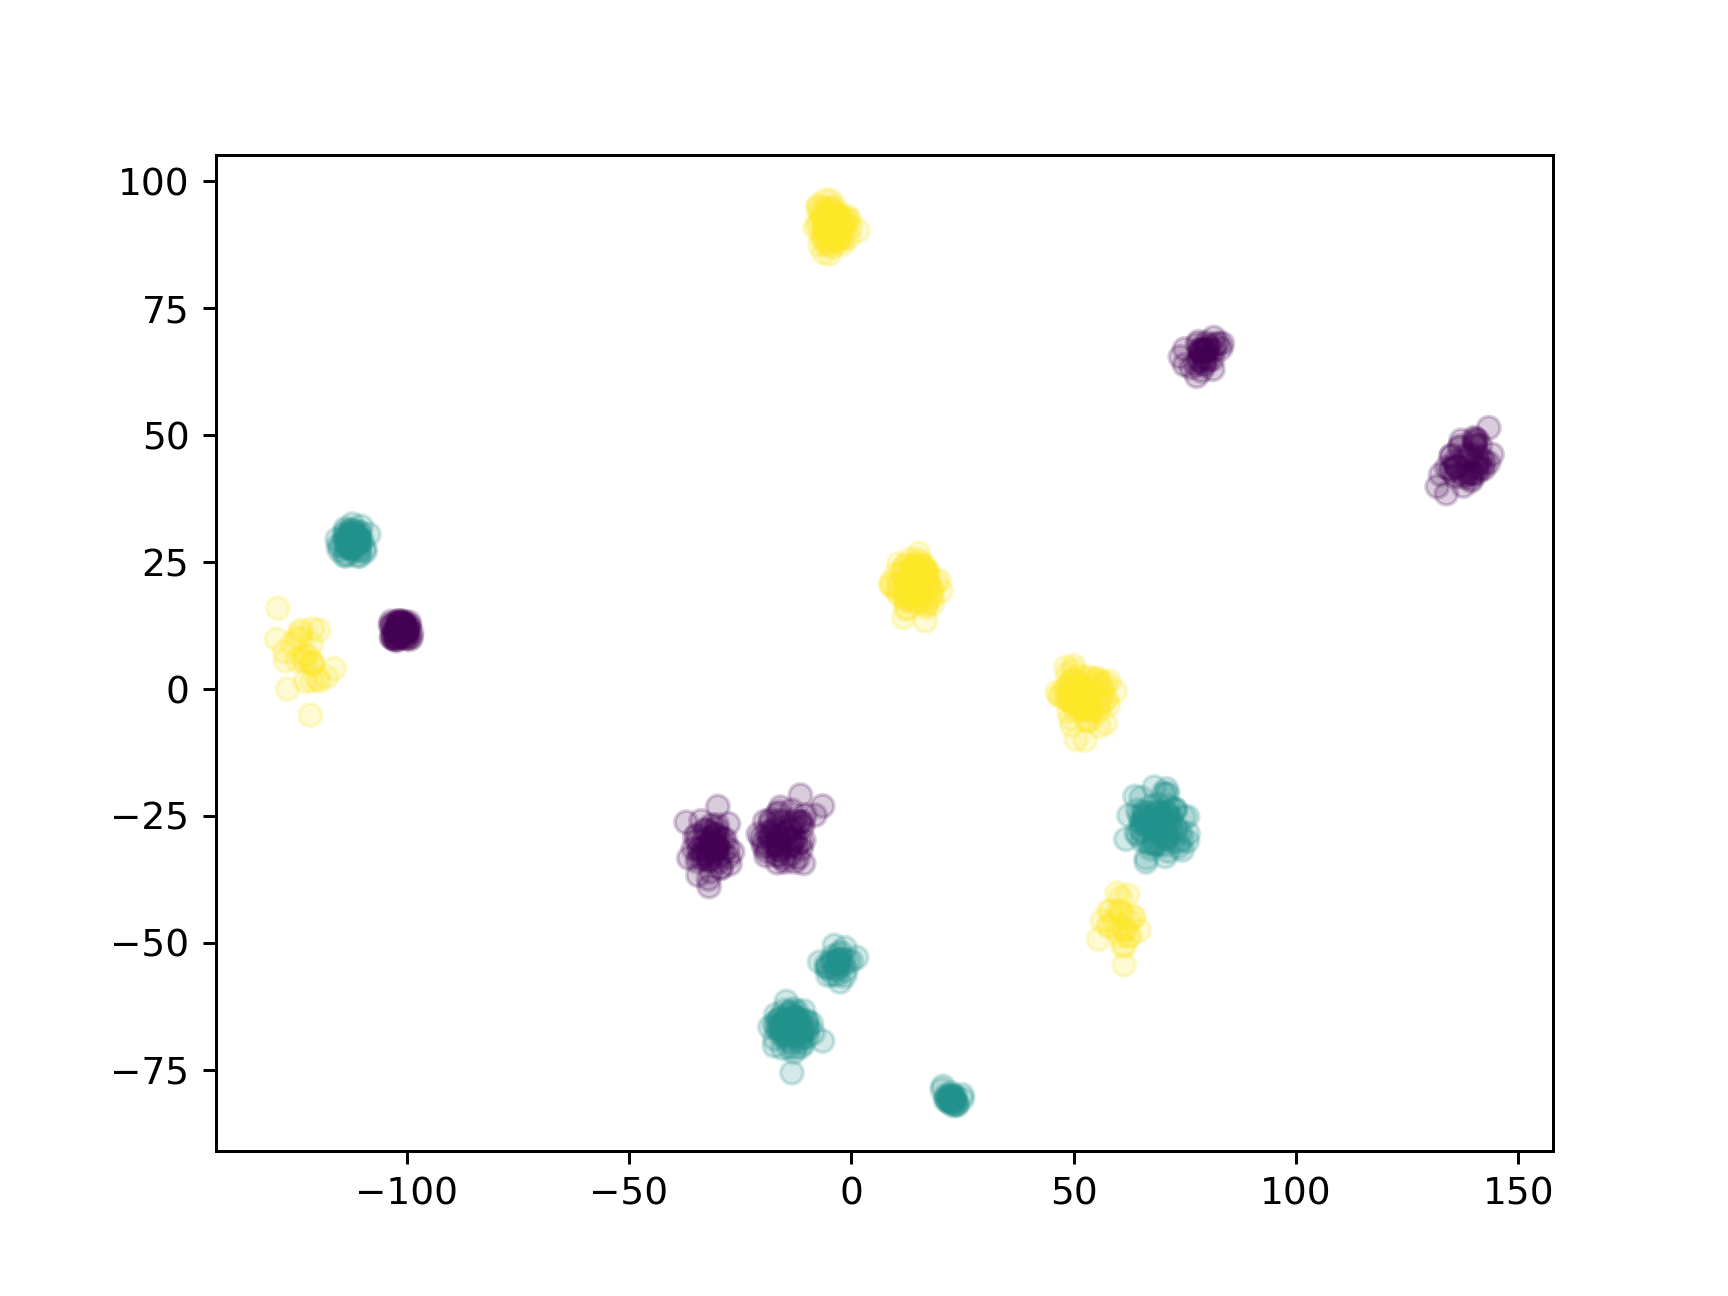

In [6]:
pca = PCA(n_components=2) #two most principal components
obs_new = pca.fit_transform(obs)
plt.scatter(obs_new[:,0],obs_new[:,1],alpha=0.2,c=states)
plt.show()

I see 3 clusters.

## Problem 2

Samples.zip contains 30 recordings for each of the words/phrases mathematics, biology, political science, psychology, and statistics. These audio samples are 2 seconds in
duration, recorded at a rate of 44100 samples per second, with samples stored as 16-bit signed
integers in WAV format. 
Load the recordings into Python using scipy.io.wavfile.read

Extract the MFCCs from each sample using code from the file MFCC.py.
Store the MFCCs for each word in a separate list. You should have five lists, each containing
30 MFCC arrays, corresponding to each of the five words under consideration.

In [7]:
subjects = {"Mathematics":[],"Biology":[],"PoliticalScience":[],"Psychology":[],"Statistics":[]}


def get_key(file):
    for i,name in enumerate(subjects.keys()):
        if name in file:
            return list(subjects.keys())[i]
    return None

for file in glob("Samples/samples/*.wav"):
    samplerate, data = wavfile.read(file)
    new_data = MFCC.extract(data, show = False) #data organization
    key = get_key(file)
    subjects[key].append(new_data)

C:\Users\sgold\AppData\Local\Temp/ipykernel_35244/2089028782.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read(file)


## Problem 3

Partition each list of MFCCs into a training set of 20 samples, and a test set of
the remaining 10 samples.
Using the training sets, train a GMMHMM on each of the words from the previous problem
with at least 10 random restarts, keeping the best model for each word (the one with the highest
log-likelihood).

In [9]:
def initialize(n_states):
    transmat = np.ones((n_states,n_states))/float(n_states)
    for i in range(n_states):
        transmat[i,:] += np.random.uniform(-1./n_states,1./n_states,n_states)
        transmat[i,:] /= sum(transmat[i,:])
    startprob = np.ones(n_states)/float(n_states) + np.random.uniform(-1./n_states,1./n_states,n_states)
    startprob /= sum(startprob)
    return startprob, transmat

In [10]:
best_models = {}
for i,key in enumerate(subjects.keys()):
    key = list(subjects.keys())[i]
    data_sets = np.random.permutation(subjects[key])
    train_sets = data_sets[:20]
    test_sets = data_sets[20:]
    subjects[key] = (train_sets,test_sets)

c:\miniconda\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [12]:
for i,key in enumerate(subjects.keys()):
    best_llkhd = -np.inf
    key = list(subjects.keys())[i]
    
    data = subjects[key][0]
    lengths = [data[0].shape[0]] * len(data)
    data_collected = np.vstack(data)
    
    for i in range(10): #ten iteration training loop
        startprob, transmat = initialize(5)
        model = hmm.GMMHMM(n_components=5,covariance_type="diag",init_params="mc")

        model.startprob_ = startprob
        model.transmat_ = transmat

        model.fit(data_collected)
        llkhd = model.monitor_.history[-1] #log llkhd
        print(llkhd,best_llkhd)
        if llkhd > best_llkhd:
            print("assigning best model")
            best_llkhd = llkhd
            best_models[key] = model

c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-37811.53812290462 -inf
assigning best model


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-37562.36296424542 -37811.53812290462
assigning best model


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-37560.19215589425 -37562.36296424542
assigning best model


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-37560.55430471928 -37560.19215589425


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-37518.48693509348 -37560.19215589425
assigning best model


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-37558.3803404603 -37518.48693509348


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-37561.5448764627 -37518.48693509348


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-37562.128782505206 -37518.48693509348


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-37808.88781912843 -37518.48693509348


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-37560.73630469343 -37518.48693509348


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-34535.01614648945 -inf
assigning best model


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-34537.74151162985 -34535.01614648945


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-34545.32962762633 -34535.01614648945


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-34530.988311641384 -34535.01614648945
assigning best model


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-34529.73624763317 -34530.988311641384
assigning best model


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-34540.257066233164 -34529.73624763317


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-34530.991013840794 -34529.73624763317


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-34530.98132813744 -34529.73624763317


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-34540.06114030336 -34529.73624763317


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-34530.15846680875 -34529.73624763317


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-68634.7068645563 -inf
assigning best model


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-68634.7932490569 -68634.7068645563


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-68635.24571072312 -68634.7068645563


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-68634.9100702943 -68634.7068645563


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-68634.91612426146 -68634.7068645563


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-68634.90029872533 -68634.7068645563


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-68639.00098530122 -68634.7068645563


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-68635.37079206028 -68634.7068645563


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-68635.05076049622 -68634.7068645563


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-68635.51037235642 -68634.7068645563


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-33662.495583806594 -inf
assigning best model


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-33755.80406241281 -33662.495583806594


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-33851.48098161779 -33662.495583806594


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-33850.60898432743 -33662.495583806594


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-33850.437086297934 -33662.495583806594


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-33842.709076084866 -33662.495583806594


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-33856.251090080514 -33662.495583806594


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-33845.73066569492 -33662.495583806594


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-33850.09546666759 -33662.495583806594


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-33842.90524244978 -33662.495583806594


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-32068.918061116576 -inf
assigning best model


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-32013.106227295553 -32068.918061116576
assigning best model


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-32058.171219659234 -32013.106227295553


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-32013.62246520785 -32013.106227295553


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-32084.851058103875 -32013.106227295553


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-32018.88813072447 -32013.106227295553


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-32020.57263996141 -32013.106227295553


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-32018.95110223817 -32013.106227295553


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-32070.829256567944 -32013.106227295553


c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

-32071.087568871844 -32013.106227295553


## Problem 4

Find the classification accuracies of the five GMMHMMs, and return a dictionary
where the words/phrases are the keys, and the values are the percent accuracies.

In [13]:
#get accuracies
test_words = {}
word_mappings = {}
for i,key in enumerate(best_models.keys()): #iterate over words
    word_mappings[key] = []
    data = subjects[key][1]
    #iterate over best models 10 times
    for data_collected in data:
        best_score = -np.inf
        for word,model in zip(best_models.keys(),best_models.values()):
            score = model.score(data_collected)
            if score > best_score: #model selection
                print("assigning a model")
                best_score = score
                best_word = word
        word_mappings[key].append(best_word)
            

assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning a model
assigning 

In [14]:
word_mappings #visualize results

{'Mathematics': ['Mathematics',
  'Mathematics',
  'Mathematics',
  'Mathematics',
  'Mathematics',
  'Mathematics',
  'Mathematics',
  'Mathematics',
  'Mathematics',
  'Mathematics'],
 'Biology': ['Biology',
  'Biology',
  'Biology',
  'Biology',
  'Biology',
  'Biology',
  'Biology',
  'Biology',
  'Biology',
  'Biology'],
 'PoliticalScience': ['PoliticalScience',
  'PoliticalScience',
  'PoliticalScience',
  'PoliticalScience',
  'PoliticalScience',
  'PoliticalScience',
  'PoliticalScience',
  'PoliticalScience',
  'PoliticalScience',
  'PoliticalScience',
  'PoliticalScience'],
 'Psychology': ['Psychology',
  'Psychology',
  'Psychology',
  'Psychology',
  'Psychology',
  'Psychology',
  'Biology',
  'Psychology',
  'Psychology',
  'Psychology'],
 'Statistics': ['Statistics',
  'Statistics',
  'Statistics',
  'Statistics',
  'Statistics',
  'Statistics',
  'Statistics',
  'Statistics',
  'Statistics',
  'Statistics']}

In [15]:
model_accs = {'Mathematics':None,'Biology':None,'PoliticalScience':None,'Psychology':None,'Statistics':None}
for word in model_accs.keys():
    preds = np.array(word_mappings[word])
    score = len(preds[preds==word]) / len(preds) #calculate accuracy
    model_accs[word] = score

In [16]:
model_accs

{'Mathematics': 1.0,
 'Biology': 1.0,
 'PoliticalScience': 1.0,
 'Psychology': 0.9,
 'Statistics': 1.0}